In [12]:
from analysis import analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from copy import deepcopy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [3]:
company_name = 'ITC'
analyse = analysis(company_name)
share_price_arr = analyse.share_price_range('4y', '1d')
print(share_price_arr)

[{'Date': '2021-03-15', 'Open': 178.41, 'High': 178.54, 'Low': 174.72, 'Close': 178.06, 'Volume': 41115805.0}, {'Date': '2021-03-16', 'Open': 178.88, 'High': 181.05, 'Low': 177.63, 'Close': 180.14, 'Volume': 48763187.0}, {'Date': '2021-03-17', 'Open': 183.91, 'High': 185.38, 'Low': 180.75, 'Close': 182.52, 'Volume': 78578698.0}, {'Date': '2021-03-18', 'Open': 184.6, 'High': 189.89, 'Low': 183.65, 'Close': 188.64, 'Volume': 91993104.0}, {'Date': '2021-03-19', 'Open': 189.81, 'High': 196.0, 'Low': 186.82, 'Close': 193.23, 'Volume': 134184994.0}, {'Date': '2021-03-22', 'Open': 193.53, 'High': 196.22, 'Low': 191.97, 'Close': 195.87, 'Volume': 46050245.0}, {'Date': '2021-03-23', 'Open': 195.01, 'High': 197.69, 'Low': 191.8, 'Close': 192.58, 'Volume': 41564683.0}, {'Date': '2021-03-24', 'Open': 191.54, 'High': 193.1, 'Low': 186.55, 'Close': 187.16, 'Volume': 27609243.0}, {'Date': '2021-03-25', 'Open': 186.47, 'High': 187.16, 'Low': 181.18, 'Close': 183.39, 'Volume': 40681282.0}, {'Date': '20

In [14]:
df = pd.DataFrame(share_price_arr)
df = df[['Date', 'Close']]

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
print(df)

             Close
Date              
2021-03-15  178.06
2021-03-16  180.14
2021-03-17  182.52
2021-03-18  188.64
2021-03-19  193.23
...            ...
2025-03-07  403.90
2025-03-10  405.00
2025-03-11  406.20
2025-03-12  412.40
2025-03-13  412.05

[990 rows x 1 columns]


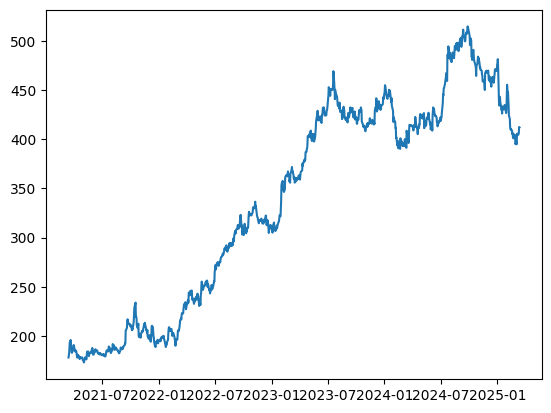

In [15]:
plt.plot(df.index, df['Close'])

In [16]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df


In [17]:
windowd_df = df_to_windowed_df(df, '2024-03-13', '2025-03-12', n=3)
print(windowd_df)

    Target Date  Target-3  Target-2  Target-1  Target
0    2024-03-13    400.03    396.01    391.23  408.64
1    2024-03-14    396.01    391.23    408.64  405.93
2    2024-03-15    391.23    408.64    405.93  405.40
3    2024-03-18    408.64    405.93    405.40  403.80
4    2024-03-19    405.93    405.40    403.80  396.16
..          ...       ...       ...       ...     ...
243  2025-03-06    397.45    394.85    405.05  405.70
244  2025-03-07    394.85    405.05    405.70  403.90
245  2025-03-10    405.05    405.70    403.90  405.00
246  2025-03-11    405.70    403.90    405.00  406.20
247  2025-03-12    403.90    405.00    406.20  412.40

[248 rows x 5 columns]


In [18]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [19]:
dates, X, y = windowed_df_to_date_X_y(windowd_df)

dates.shape, X.shape, y.shape

((248,), (248, 3, 1), (248,))

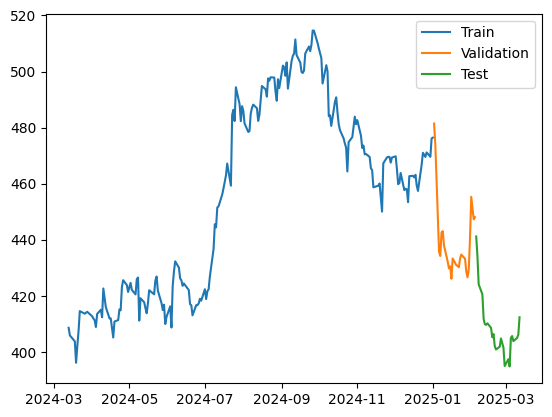

In [20]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 9s 306ms/step - loss: 208749.7500 - mean_absolute_error: 455.6243 - val_loss: 191852.9219 - val_mean_absolute_error: 437.8017
Epoch 2/100
7/7 [==============================] - 0s 25ms/step - loss: 207963.7969 - mean_absolute_error: 454.7599 - val_loss: 191194.7344 - val_mean_absolute_error: 437.0494
Epoch 3/100
7/7 [==============================] - 0s 26ms/step - loss: 207259.4375 - mean_absolute_error: 453.9834 - val_loss: 190424.2188 - val_mean_absolute_error: 436.1671
Epoch 4/100
7/7 [==============================] - 0s 23ms/step - loss: 206407.6562 - mean_absolute_error: 453.0470 - val_loss: 189535.9375 - val_mean_absolute_error: 435.1475
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 205359.9531 - mean_absolute_error: 451.8878 - val_loss: 188267.5625 - val_mean_absolute_error: 433.6877
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 203911.5000 - mean_absolute_error: 450.2844 - v

7/7 [==============================] - 2s 5ms/step


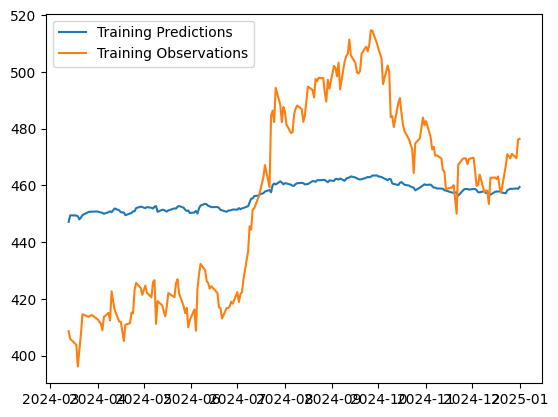

In [22]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 66ms/step


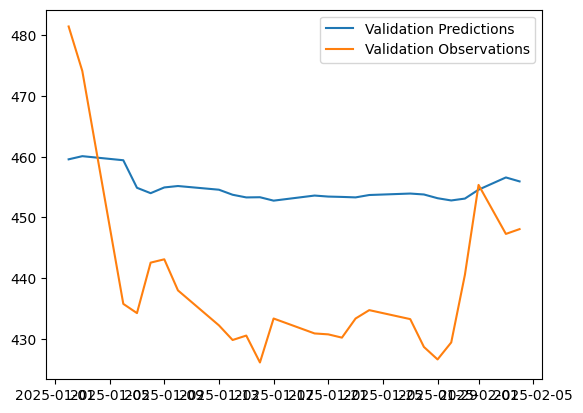

In [23]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 101ms/step


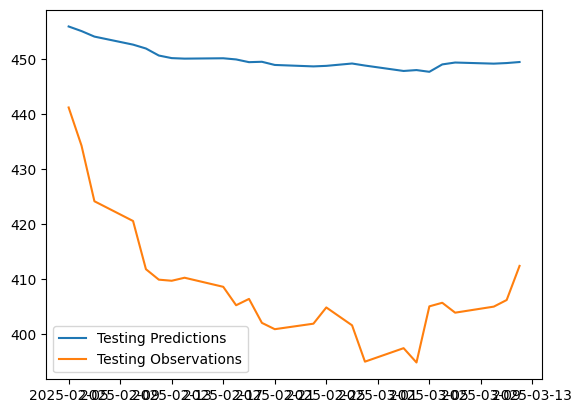

In [24]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

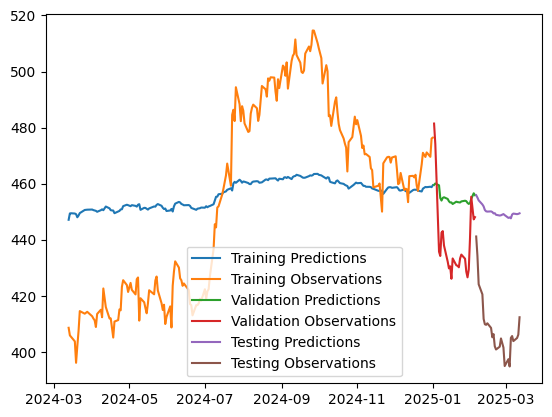

In [25]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])